# Problem description

Company XYZ has decided to offer a shuttle bus to help its employees commute from San Francisco to Mountain View. The city of San Francisco has given the company a list of potential bus stop locations to choose from and asked that no more than 10 stops be within the city.

You have been given the home addresses of all employees interested in taking the shuttle and have been asked to come up with the ten most efficient stops. While you have been given some freedom in defining what is "efficient," the general consensus within the company is that the most efficient way to select the bus stops is to minimize the overall walking distance between employee homes and the closest bus stop.

Estimating all possible combinations of 10 stops would require a lot of time (how many combinations would that be?). Therefore, your boss is fine with simplifying the problem and returning 10 stops that have a high probability of being the best stops.

You should write an algorithm that returns the best 10 stops in your opinion. Also, please explain the rationale behind the algorithm.

# Data pre-processing

- I converted Employee_Addresses.csv into latitude and longitude data using the OpenCage library.
- I attempted to convert Potential_Bus_Stops.csv into latitude and longitude data.
- I performed a quality check on the data using the visualization tool Folium. It became evident that the OpenCage library could not accurately convert junction-type data in Potential_Bus_Stops.csv. The data lacks postcodes and other crucial information required for precise conversion.
- To address this issue, I used another conversion library from Google, Geocode. Both libraries require API keys, which can be obtained from their respective websites. 
- Google's API successfully converted the data with better accuracy.


In [ ]:
%%capture
%pip install opencage
%pip install folium

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import folium   
from opencage.geocoder import OpenCageGeocode
import requests

In [3]:
a = pd.read_csv('Employee_Addresses.csv')
print(len(set(a.employee_id)))
a = a.set_index('employee_id').sort_index()
print(a.address.isnull().any())
a

2191
False


,address
employee_id,
1,"220 Surrey St, San Francisco, CA 94131, USA"
2,"110 Madrid St, San Francisco, CA 94112, USA"
3,"1224 Athens St, San Francisco, CA 94112, USA"
4,"171 Accacia St, Daly City, CA 94014, USA"
5,"98 Brosnan St, San Francisco, CA 94103, USA"
...,...
2187,"560 Vienna St, San Francisco, CA 94112, USA"
2188,"808 Twin Peaks Blvd, San Francisco, CA 94131, USA"
2189,"831 Russia Ave, San Francisco, CA 94112, USA"


In [ ]:
# You have to register with OpenCageGeocode and get this key. The limit is 2500 queries/day
API_KEY = '##########'
geocoder = OpenCageGeocode(API_KEY)

def get_coordinates_opencage(address):

    try:
        result = geocoder.geocode(address)
        if result:
            location = result[0]['geometry']
            return location['lat'], location['lng']
        else:
            return None, None
    except Exception as e:
        print("Error")
        return None, None

a[['latitude', 'longitude']] = a['address'].apply(get_coordinates_opencage).apply(pd.Series)
a

,address,latitude,longitude
employee_id,,,
1,"220 Surrey St, San Francisco, CA 94131, USA",37.735914,-122.435537
2,"110 Madrid St, San Francisco, CA 94112, USA",37.727706,-122.428450
3,"1224 Athens St, San Francisco, CA 94112, USA",37.712354,-122.436421
4,"171 Accacia St, Daly City, CA 94014, USA",37.705621,-122.415369
5,"98 Brosnan St, San Francisco, CA 94103, USA",37.768792,-122.423023
...,...,...,...
2187,"560 Vienna St, San Francisco, CA 94112, USA",37.719635,-122.431300
2188,"808 Twin Peaks Blvd, San Francisco, CA 94131, USA",37.750202,-122.447441
2189,"831 Russia Ave, San Francisco, CA 94112, USA",37.718447,-122.430185


In [ ]:
print(a.isnull().any().any())
a.to_csv('Employee_Addresses_lat_long.csv')

In [ ]:
#  A list of potential bus stop locations to choose from. Later must select 10 stops within the city
b = pd.read_csv('Potentail_Bust_Stops.csv')
print(b.Street_One.value_counts(dropna=False))
print(b.isnull().any().any())
b

Street_One
MISSION ST    119
Name: count, dtype: int64


,Street_One,Street_Two
0,MISSION ST,ITALY AVE
1,MISSION ST,NEW MONTGOMERY ST
2,MISSION ST,01ST ST
3,MISSION ST,20TH ST
4,MISSION ST,FREMONT ST
...,...,...
114,MISSION ST,NIAGARA AVE
115,MISSION ST,ACTON ST
116,MISSION ST,05TH ST
117,MISSION ST,24TH ST


In [ ]:
geocoder = OpenCageGeocode(API_KEY)

def get_coordinates_opencage_intersection(row):

    try:
        
        address = str(row['Street_One']) + " & " + str(row['Street_Two']) + ", San Francisco, CA, USA"

        result = geocoder.geocode(address)
        if result:
            location = result[0]['geometry']
            return location['lat'], location['lng']
        else:
            return None, None
    except Exception as e:
        print("Error in geocoding")
        return None, None

In [34]:
%%time 

latitude, longitude  = [], []
for index, row in b.iterrows():
    lat, lon = get_coordinates_opencage_intersection(row)
    latitude.append(lat)
    longitude.append(lon)

b['latitude'] = latitude
b['longitude'] = longitude
b

CPU times: total: 516 ms
Wall time: 2min 40s


,Street_One,Street_Two,latitude,longitude
0,MISSION ST,ITALY AVE,37.790461,-122.396690
1,MISSION ST,NEW MONTGOMERY ST,37.786209,-122.398977
2,MISSION ST,01ST ST,37.790461,-122.396690
3,MISSION ST,20TH ST,37.790461,-122.396690
4,MISSION ST,FREMONT ST,37.790461,-122.396690
...,...,...,...,...
114,MISSION ST,NIAGARA AVE,37.716431,-122.442760
115,MISSION ST,ACTON ST,37.790461,-122.396690
116,MISSION ST,05TH ST,37.790461,-122.396690
117,MISSION ST,24TH ST,37.790461,-122.396690


In [ ]:
print(b.isnull().any().any())

False


- From the map below, we see that pre-processing Potentail_Bust_Stops.csv is more difficult, e.g. no postcode of the junction, and OpenCageGeocode struggles to find the junction. 

- You can see on the map below, that the bus stops are mapped in the wrong places and far away from the Mission road. 

In [ ]:
map = folium.Map(location=[37.7749, -122.4194], zoom_start=12) # centered San Francisco

for idx, row in b.iterrows():
        folium.Marker( location=[row['latitude'], row['longitude']], popup=row['Street_Two'] ).add_to(map)
map

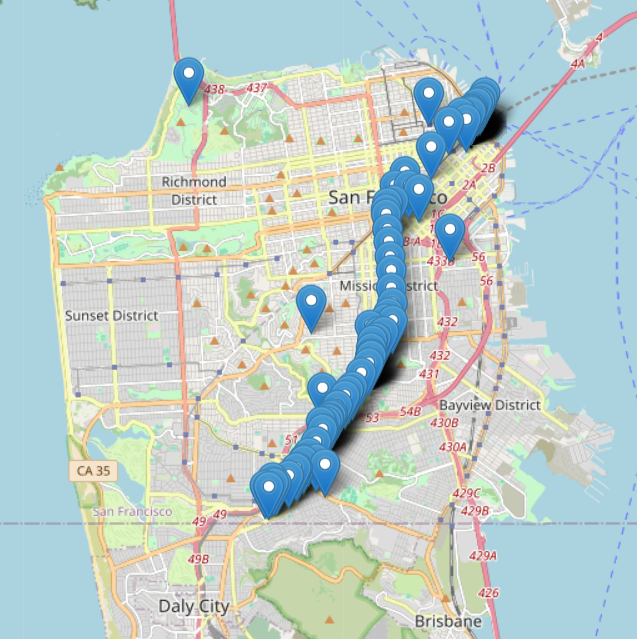

- Pre-process "b" again using Google API - geocode

In [67]:
# Reload buses addresses
b = pd.read_csv('Potentail_Bust_Stops.csv')
b

,Street_One,Street_Two
0,MISSION ST,ITALY AVE
1,MISSION ST,NEW MONTGOMERY ST
2,MISSION ST,01ST ST
3,MISSION ST,20TH ST
4,MISSION ST,FREMONT ST
...,...,...
114,MISSION ST,NIAGARA AVE
115,MISSION ST,ACTON ST
116,MISSION ST,05TH ST
117,MISSION ST,24TH ST


In [ ]:
API_KEY = '###############'
base_url = 'https://maps.googleapis.com/maps/api/geocode/json'

def get_coordinates_google_api(row):
    try:
        address = str(row['Street_One']) + " & " + str(row['Street_Two']) + ", San Francisco, CA, USA"

        params = {'address': address,  'key': API_KEY }
        response = requests.get(base_url, params=params)
        response_json = response.json()
        if response_json['status'] == 'OK':
            location = response_json['results'][0]['geometry']['location']
            return location['lat'], location['lng']
        else:
            print("Error")
            return None, None
    except Exception as e:
        print("Error: %" %e)
        return None, None

In [68]:
%%time 

latitude, longitude  = [], []
for index, row in b.iterrows():
    lat, lon = get_coordinates_google_api(row)
    latitude.append(lat)
    longitude.append(lon)

b['latitude'] = latitude
b['longitude'] = longitude
b

CPU times: total: 562 ms
Wall time: 40.6 s


,Street_One,Street_Two,latitude,longitude
0,MISSION ST,ITALY AVE,37.718475,-122.439532
1,MISSION ST,NEW MONTGOMERY ST,37.787462,-122.400526
2,MISSION ST,01ST ST,37.789782,-122.397587
3,MISSION ST,20TH ST,37.758648,-122.419081
4,MISSION ST,FREMONT ST,37.790474,-122.396721
...,...,...,...,...
114,MISSION ST,NIAGARA AVE,37.715586,-122.441725
115,MISSION ST,ACTON ST,37.708808,-122.452707
116,MISSION ST,05TH ST,37.782731,-122.406509
117,MISSION ST,24TH ST,37.752248,-122.418458


In [ ]:
map = folium.Map(location=[37.7749, -122.4194], zoom_start=12) # centered San Francisco

for idx, row in b.iterrows():
        folium.Marker( location=[row['latitude'], row['longitude']], popup=row['Street_Two'] ).add_to(map)
map

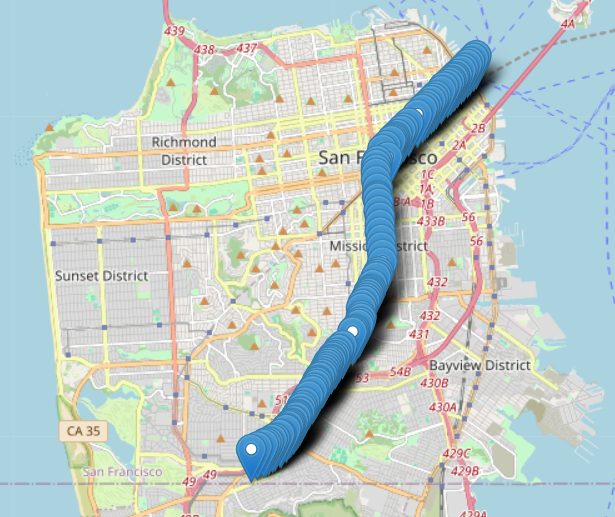

- This looks much better, something I can work with. Ideally need to use this Google API - Geocode to pre-process the adresses of employees, but I assume that they are ok for now (because of time constrainst)

In [72]:
print(b.isnull().any().any())
b.to_csv('Potentail_Bust_Stops_lat_long_corrected.csv') 

False


# Check and plot pre-processed data on xy

In [73]:
b = pd.read_csv('Potentail_Bust_Stops_lat_long_corrected.csv').drop(columns="Unnamed: 0")
a = pd.read_csv('Employee_Addresses_lat_long.csv').set_index('employee_id')
b

,Street_One,Street_Two,latitude,longitude
0,MISSION ST,ITALY AVE,37.718475,-122.439532
1,MISSION ST,NEW MONTGOMERY ST,37.787462,-122.400526
2,MISSION ST,01ST ST,37.789782,-122.397587
3,MISSION ST,20TH ST,37.758648,-122.419081
4,MISSION ST,FREMONT ST,37.790474,-122.396721
...,...,...,...,...
114,MISSION ST,NIAGARA AVE,37.715586,-122.441725
115,MISSION ST,ACTON ST,37.708808,-122.452707
116,MISSION ST,05TH ST,37.782731,-122.406509
117,MISSION ST,24TH ST,37.752248,-122.418458


In [74]:
a

,address,latitude,longitude
employee_id,,,
1,"220 Surrey St, San Francisco, CA 94131, USA",37.735914,-122.435537
2,"110 Madrid St, San Francisco, CA 94112, USA",37.727706,-122.428450
3,"1224 Athens St, San Francisco, CA 94112, USA",37.712354,-122.436421
4,"171 Accacia St, Daly City, CA 94014, USA",37.705621,-122.415369
5,"98 Brosnan St, San Francisco, CA 94103, USA",37.768792,-122.423023
...,...,...,...
2187,"560 Vienna St, San Francisco, CA 94112, USA",37.719635,-122.431300
2188,"808 Twin Peaks Blvd, San Francisco, CA 94131, USA",37.750202,-122.447441
2189,"831 Russia Ave, San Francisco, CA 94112, USA",37.718447,-122.430185


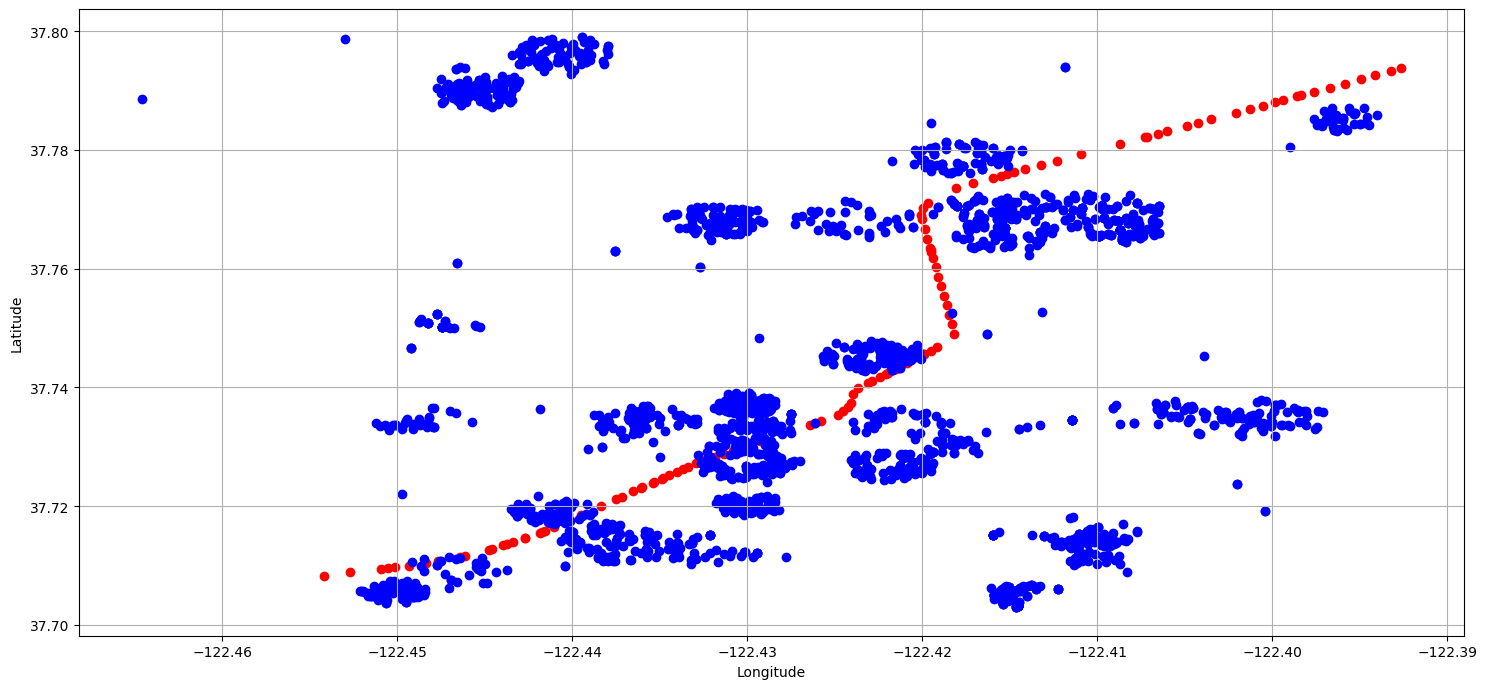

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15, 7))

# Plot 1 - potential bus stops
axs.scatter(b['longitude'], b['latitude'], c='red', marker='o')
axs.set_xlabel('Longitude'); axs.set_ylabel('Latitude'); axs.grid(True)

# Plot 2 - addresses of all employees
axs.scatter(a['longitude'], a['latitude'], c='blue', marker='o')
plt.tight_layout()